In [1]:
import matplotlib
%matplotlib inline
import os
import astropy
import sourcefinder
import logging
import pandas
from astropy.coordinates import SkyCoord
import astropy.units as u

In [2]:
datadir = "../data/"
datafiles = [datadir + i for i in sorted(j for j in os.listdir(datadir) if j.endswith(".fits"))]

In [3]:
# we can move this to a helper script
from sourcefinder.accessors import open as open_accessor
from sourcefinder.accessors import sourcefinder_image_from_accessor

def extract_sources(path, margin=10, extraction_radius_pix=400, back_size_x=32, back_size_y=32,
                    residuals=True, detection_threshold=5, analysis_threshold=3,
                    deblend_nthresh=0, force_beam=True):

    accessor = open_accessor(path, plane=0)
    data_image = sourcefinder_image_from_accessor(accessor,
                    margin=margin,
                    radius=extraction_radius_pix,
                    back_size_x=back_size_x,
                    back_size_y=back_size_y)

    return data_image.extract(
        det=detection_threshold,
        anl=analysis_threshold,
        deblend_nthresh=deblend_nthresh,
        force_beam=force_beam
)

In [4]:
sources = extract_sources(datafiles[0])

No handlers could be found for logger "sourcefinder.accessors.fitsimage"
/home/gijs/Work/pyse/sourcefinder/image.py:761: RuntimeWarning: invalid value encountered in greater
  (self.data_bgsubbed > analysisthresholdmap) &


In [5]:
first_astro_sources = SkyCoord([SkyCoord(ra=i.ra.value*u.degree, dec=i.dec.value*u.degree, frame='icrs') for i in sources])

In [6]:
lightcurves = [[i.flux.value] for i in sources]

In [7]:
for datafile in datafiles[1:]:
    print(datafile)
    next_sources = extract_sources(datafile)
    next_astro_sources = SkyCoord([SkyCoord(ra=i.ra.value*u.degree, dec=i.dec.value*u.degree, frame='icrs') for i in next_sources])
    idx1, idx2, sep2d, _ = astropy.coordinates.search_around_sky(next_astro_sources,
                                                                 first_astro_sources,
                                                                 seplimit=5.68*u.degree,
                                                                 storekdtree=True)
    [lightcurves[i2].append(next_sources[i1].flux.value) for i1, i2 in zip(idx1, idx2)]

../data/20160831151015UTC_S307.5_I16x1_W6_A1.5.fits
../data/20160831151016UTC_S307.5_I16x1_W6_A1.5.fits
../data/20160831151017UTC_S307.5_I16x1_W6_A1.5.fits
../data/20160831151018UTC_S307.5_I16x1_W6_A1.5.fits
../data/20160831151019UTC_S307.5_I16x1_W6_A1.5.fits
../data/20160831151020UTC_S307.5_I16x1_W6_A1.5.fits
../data/20160831151021UTC_S307.5_I16x1_W6_A1.5.fits
../data/20160831151022UTC_S307.5_I16x1_W6_A1.5.fits
../data/20160831151023UTC_S307.5_I16x1_W6_A1.5.fits
../data/20160831151024UTC_S307.5_I16x1_W6_A1.5.fits
../data/20160831151025UTC_S307.5_I16x1_W6_A1.5.fits
../data/20160831151026UTC_S307.5_I16x1_W6_A1.5.fits
../data/20160831151027UTC_S307.5_I16x1_W6_A1.5.fits
../data/20160831151028UTC_S307.5_I16x1_W6_A1.5.fits
../data/20160831151029UTC_S307.5_I16x1_W6_A1.5.fits
../data/20160831151030UTC_S307.5_I16x1_W6_A1.5.fits
../data/20160831151031UTC_S307.5_I16x1_W6_A1.5.fits
../data/20160831151032UTC_S307.5_I16x1_W6_A1.5.fits


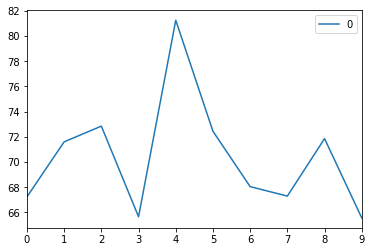

In [11]:
_ = pandas.DataFrame(lightcurves[1]).plot()